# open mitgcm outputs, cube sphere

---

In [1]:
from xmitgcm import open_mdsdataset
import xmitgcm.utils as xgu
import subprocess
import os
import numpy as np
import dask.array as dsa
import dask
import xarray as xr

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/xyu/dask/scheduler.json'))
#client = Client()

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [4]:
client.restart()
client

Client Scheduler: tcp://10.148.0.184:8786 Dashboard: http://10.148.0.184:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


In [5]:
#data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
data_dir = '/home/datawork-lops-osi/data/mit4320/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

In [6]:
dtype = np.dtype('>f4')

# can complete 300 files in < 12 hours
#nfiles = 300
nfiles = 2

# the first available iteration is iter0=10368

delta_t = 25. # seconds
all_iters = np.arange(10368, 1310544+1, 144)
time = delta_t * all_iters
    
ds = open_mdsdataset(data_dir, grid_dir=grid_dir,
                     iters=list(all_iters)[:1], geometry='llc', read_grid=True,
                     default_dtype=np.dtype('>f4'), delta_t=delta_t,
                     ignore_unknown_vars=True)

# fix time
del ds['iter']
ds['time'] = xr.Variable(('time',), time, ds.time.attrs)
ds.time.attrs['units'] = 'seconds since 2011-09-10'
ds['iter'] = xr.Variable(('time',), all_iters)
ds

# get shape
nz, nface, ny, nx = ds.hFacC.shape

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /home/datawork-lops-osi/data/mit4320/. Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [7]:
index_fname = 'llc4320_compressed_level_index.nc'

try:
    ds_index = xr.open_dataset(grid_dir+index_fname)
except OSError:
    # compute and save mask indices
    print('Create llc4320_compressed_level_index.nc in grid_dir')
    ds_index = ((ds.reset_coords()[['hFacC', 'hFacW','hFacS']] > 0).sum(axis=(1, 2, 3)))
    ds_index.coords['k'] = ds.k
    ds_index.load().to_netcdf(grid_dir+index_fname)
    print('done')
    
ds_index

<xarray.Dataset>
Dimensions:  (k: 90)
Coordinates:
    Z        (k) float32 ...
    drF      (k) float32 ...
    PHrefC   (k) float32 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    hFacC    (k) int64 ...
    hFacW    (k) int64 ...
    hFacS    (k) int64 ...

In [8]:
ddir = data_dir+'Eta/'

def load_level_from_3D_field(varname, inum, offset, count, mask, dtype):
    inum_str = '%010d' % inum
    fname = os.path.join(ddir, '%s.%s.data.shrunk' % (varname, inum_str))
    
    with open(fname, mode='rb') as file:
        file.seek(offset * dtype.itemsize)
        data = np.fromfile(file, dtype=dtype, count=count)
    
    data_blank = np.full_like(mask, np.nan, dtype='f4')
    data_blank[mask] = data
    data_blank.shape = mask.shape
    data_llc = xgu._reshape_llc_data(data_blank, jdim=0).compute(get=dask.get)
    data_llc.shape = (1,) + data_llc.shape
    return data_llc

def lazily_load_level_from_3D_field(varname, inum, offset, count, mask, dtype):
    return dsa.from_delayed(dask.delayed(load_level_from_3D_field)
                            (varname, inum, offset, count, mask, dtype),
                            (1, nface, ny, nx), dtype)


def make_data_variable(varname, all_iters, k=0, point='C'):
    shape = (1, nface, ny, nz)
    dtype = np.dtype('>f4')
    strides = [0,] + list(ds_index['hFac' + point].data)
    offset = strides[k]
    count = strides[k+1]
    
    # load mask from raw data
    hfac = xgu.read_mds(grid_dir + 'hFac' + point,
                        use_mmap=True, dask_delayed=False, force_dict=False)
    mask = hfac[k]>0
    mask_future = client.scatter(mask)
    
    data = dsa.concatenate([lazily_load_level_from_3D_field
                            (varname, i, offset, count, mask_future, dtype)
                            for i in all_iters], axis=0)
    
    return data

In [9]:
ds_subset = ds.isel(time=slice(0,10))
ds_subset['eta'] = xr.Variable(['time', 'face', 'j', 'i'],
                               make_data_variable('Eta', ds_subset.iter))
ds_subset[['eta']]
print('eta data size: %.1f GB' %(ds_subset.nbytes / 1e9))
#ds = xr.Variable(['time', 'face', 'j', 'i'], make_data_variable('Eta', [314496]))
#ds.compute()

eta data size: 284.3 GB


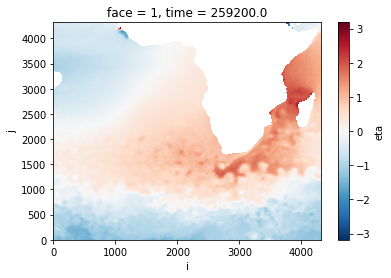

In [10]:
ds_subset['eta'].isel(face=1,time=0).plot()

In [11]:
# store faces bounding boxes
r2d = 180./np.pi

faces = ds_subset['face'].values
flon = dict()
flat = dict()
fcenter = dict()
for f in faces:
    flon[f] = np.array([ds_subset['XC'].isel(face=f, i=i, j=j).values for i,j in zip([0,-1,-1,0],[0,0,-1,-1])])
    flat[f] = np.array([ds_subset['YC'].isel(face=f, i=i, j=j).values for i,j in zip([0,-1,-1,0],[0,0,-1,-1])])
    v = np.array([0.,0.,0.])
    for lon, lat in zip(flon[f],flat[f]):
        #v += spherical2cartesian([np.cos(lon/r2d),0.,0.], lon/r2d, lat/r2d)
        v += [np.cos(lon/r2d)*np.cos(lat/r2d), np.sin(lon/r2d)*np.cos(lat/r2d), np.sin(lat/r2d)]
    v = v/np.sqrt(np.sum(v**2))
    fcenter[f] = [np.arctan2(v[1],v[0])*r2d , np.arcsin(v[2])*r2d]

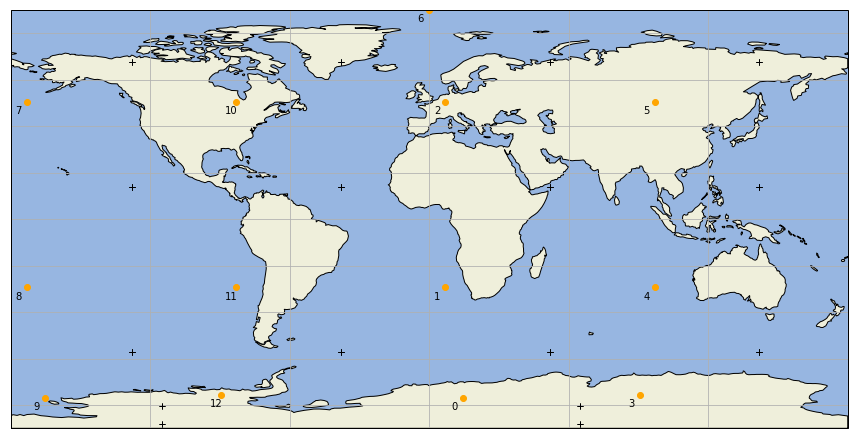

In [12]:
# plot faces on earth map
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-45, 0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines()

for f in faces:
    ax.plot(flon[f],flat[f], '+', color='k', transform=ccrs.PlateCarree())
    #ax.fill(flon[f],flat[f], color='coral', transform=ccrs.PlateCarree(), alpha=0.4)
    #
    ax.plot(fcenter[f][0], fcenter[f][1], 'o', color='orange', transform=ccrs.PlateCarree())
    ax.text(fcenter[f][0] - 5, fcenter[f][1] - 5, str(f), transform=ccrs.PlateCarree())

# plot corners
#f = faces[1]
#for i in range(len(flon[f])):
#    ax.text(flon[f][i] - 5, flat[f][i] - 5, str(i), transform=ccrs.PlateCarree())
